# League of Legends Data Analysis Tutorial

*Andrew Sarama, Elisabeth Jang*  
*May 15, 2022*  
*University of Maryland, College Park*  
*Department of Computer Science and Mathematics*  

## Brief Introduction

League of Legends is a team-based 5v5 competitive Esport. Various data from previously played matches is saved to the LoL database. However, access to the database needs to be manually authenticated by the Riot Games Development Team. Luckily, authenticated API users have downloaded relevant data from thousands of games and uploaded the files for public access. This tutorial will be an effective introduction to analyzing LoL match data regardless of the user's authentication level.


### Important Game Mechanics

*Feel free to skip if you are already familiar with basic LoL gameplay*


#### Primary Game Objectives
The LoL map (also known as "The Rift") has 2 teams, *red* and *blue*. The goal of the game is to destroy the opposing team's *nexus*, located at the center of the opposing team's *base*. The nexus is protected by 4 layers of *towers*, which are non-regenerating defense turrets preventing players from simply walking into the enemy base. All 4 layers of towers must be penetrated before the nexus becomes attackable. 

#### Champions
Before the start of any match, all 10 players choose *champions* from a pool of ~150 playable characters. Champions can attack opposing champions and towers. Champions that die in combat will respawn in their base. Note that the only way to win is to destroy the opposing nexus--killing the enemy champions simply prevents them from protecting their towers and nexus. Each player gets to pick and ban exactly 1 champion.

#### Secondary Game Objectives
There are 3 secondary objectives on The Rift: killing the *Dragon*, killing the *Rift Herald*, and killing the *Baron*. All of these objectives spawn in set times and locations on The Rift, and the team that completes the objectives first gains bonuses that make destroying the opposing team's base easier.

## Data Analysis Opportunities

Using the data that is stored for LoL matches and some data analysis techniques, we can answer some of the following interesting questions (and many, many more):

1. Is the team that gets the "first blood" (first champion kill in the match) more likely to win? How good of a predictor is the first blood for the outcome of the game?
2. How does completing secondary objectives impact a team's chances of winning? Is killing the dragon a waste of player's time, or is it a predictor of success?
3. What is the relationship between a champion's win rate, pick rate, and ban rate?
4. Is focusing more on secondary objectives than primary objectives a viable strategy?

## Data Collection and Parsing

Without a private Riot Games development key, finding LoL match data with very specific paramaters is challenging. Luckily, if we want to analyze a large quantity of general matches, many such public datasets exist. This tutorial will use a free-to-download dataset containing ~50,000 matches played on the European Server. See [1] under *Resources* for a download link.

### Importing Necessary Libraries

The data will be stored in our Python code using the *pandas* library. The first step will be to import the library itself:

In [1]:
import pandas as pd

The data from this specific source has 4 files: games.csv (contains the game data) and 3 .json files for converting champion/spell IDs to their names. Let's first get the data from the games into a pandas DataFrame and observe what other data parsing needs to take place.

In [2]:
games = pd.read_csv("/home/jovyan/notebooks/Data/games.csv")

# there are a very large number of data columns, so let's look at the names of the first 11
display_cols = 11
i = 1
for col in games.columns:
    if i <= display_cols:
        display(col)
        i += 1

'gameId'

'creationTime'

'gameDuration'

'seasonId'

'winner'

'firstBlood'

'firstTower'

'firstInhibitor'

'firstBaron'

'firstDragon'

'firstRiftHerald'

These columns have very useful information about the events that took place in the match. From the description of the dataset at link [1], the 2 teams are given numerical identifiers 1 and 2. For all columns that show the 'first' (objective), they represent which team completed the objective first. However, not all objectives are necessary to win a game, so identifier 0 implies that neither team completed this objective.

Looking at the .csv file, there are a lot of columns that are unneccessary and are needlessly cluttering the data. Here we will drop all of the columns that will not be used throughout this tutorial:

In [3]:
games.drop(columns=['gameId', 'creationTime', 'seasonId'], inplace = True)

### Using JSON to Clean Up

Many of the columns use numerical identifiers for champions and spells. Replacing those entries with the actual names of the champions will make interpreting the data significantly easier. We will use the *json* library to read the .JSON files into dictionaries for a quick conversion:

In [4]:
import json

champion_info = {}; # this will be a dictionary mapping champion ID to a set of parameters
with open("/home/jovyan/notebooks/Data/champion_info.json", "r") as read_file:
    champion_info = json.load(read_file)
    champion_info = champion_info['data'] # we don't need the game version and other extraneous data

From this, let's see what information we can find about champions with ID = 1:

In [5]:
display(champion_info['1'])

{'title': 'the Dark Child', 'id': 1, 'key': 'Annie', 'name': 'Annie'}

In [6]:
def champ_name_map(id): # this function will serve as a map 
  return champion_info[id]['name']

# the dataset gives numerical id's, while all json keys are strings
games['t1_champ1'] = games['t1_champ1id'].astype(str)
games['t1_champ1'] = games['t1_champ1'].map(champ_name_map) # apply id string -> name mapping function
display(games[['t1_champ1id', 't1_champ1']].head(5))

,t1_champ1id,t1_champ1
0,8,Vladimir
1,119,Draven
2,18,Tristana
3,57,Maokai
4,19,Warwick


Having done this, any data analysis done on the champion selection of the players will now be a lot more readable! 

### Data Cleaning: Early Forfeited Games

In LoL, if a player disconnects within the first ~6 minutes of the game, the players in the game can vote to cancel the match. Games like this will prove to be outliers in a number of areas (low objective count, no tower destructions, no first bloods, etc). It makes a lot of sense to remove games like this.

A game cannot be forfeited or realistically lost before 10 minutes. Thus, any game that lasts less than 600 seconds is likely a game that was reset after a disconnect. Do any games like this exist?

In [7]:
len(games[games['gameDuration'] <= 600])

1204

So it appears that ~1200 of our games were cancelled before the 10 minute mark. These games will not be beneficial to our analysis, so lets remove them:

In [8]:
games = games[games['gameDuration'] > 600]
games.reset_index() # this is necessary as some indexes will be left empty after dropping rows
len(games)

50286

## Data Analysis Example: First Blood

As an example exercise, we will determine whether the team that gets the *first blood* (reminder: this is the team that gets the first champion kill) is more likely to win the match. We will then do some hypothesis testing to check the statistical signficance of the results.

First, let's figure out the win percentage of the team that gets the first blood. We know if the winning team gets the first blood whenever the 'winner' column is equal to the 'firstBlood' column.

In [9]:
# we are looking for the number of rows 
num_wins = len(games[games["winner"] == games["firstBlood"]])
num_games = len(games)

display((num_wins / num_games) * 100.0)

59.052221294197196

Interesting! According to the dataset, the team that gets the first blood has a 58.47% chance of winning the match. But how statistically significant is this result?

On average, two evenly matched teams should each have a winrate very close to 50%. It may be naive to assume that all teams in this dataset are "evenly matched", however there is no good way to quantify the fairness of a match. For the rest of this analysis, let's assume that teams 1 and 2 are evenly matched, and thus have an equal chance of getting the first blood. There may be conflating variables such as champion selection/archetype, but let's ignore that for now.

### Hypothesis Testing

For this hypothesis test, let's be more statistically robust. Let's consider each team as an individual (meaning there are 2 data points per match). The independent variable is whether or not a team got the first blood. The dependent variable is whether or not the team won the match. Let's filter out some dataframes that represent these variables:

In [10]:
first_blood_win = 0
first_blood_loss = 0

for index, row in games.iterrows():
    if row['firstBlood'] == row['winner']:
        first_blood_win += 1
    else:
        first_blood_loss += 1
        
display([first_blood_win, first_blood_loss])

[29695, 20591]

Now, we have a categorical dependent and independent variable. We are hoping to show that the number of observations for the dependent categories is far enough away from the expected number of observations. If the first blood in a match had no correlation with the result, then we would expect the first blood teams to have an equal number of wins and losses (since the average winrate for a team would be 50%). 

This comparison of categorical variable frequencies is perfect for a chi-square test! The scipy library can quickly do the chi-square test for us:

In [11]:
import scipy.stats as stat

expected = (first_blood_win + first_blood_loss) / 2
display(stat.chisquare(f_obs = [first_blood_win, first_blood_loss], f_exp = [expected, expected]))

Power_divergenceResult(statistic=1648.2284532474248, pvalue=0.0)

Perhaps this test wasn't necessary, considering there is an almost 5,000 observation difference from the number we would expect. Thus, the p-value of this number of observations occurring naturally is so small, that it's being rounded to 0.0. Without question, there is a correlation between the team that gets first blood and their chance of victory. But is there an example with a more reasonable p-value?

Let's discuss which champions are correlated with an increased number of wins for their team *with statistical significance*. Let's set a maximum p-value of 0.05, meaning any chi-square test that has a p-value higher than 0.05 will not have a statistically significant advantage.\

Here, I will define a function that checks the champions of each team and counts the wins and losses for teams with a specific championID (numerical parameter):

In [15]:
team1_champs = games[['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id']]
team2_champs = games[['t2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']]

def champion_win_pvalue(championID):
    win_with_champ = 0 # number of times champ is on the team and wins
    loss_with_champ = 0 # number of times champ is on the team and loses

    for index, row in team1_champs.iterrows():
        if championID in row.values: # row only contains champion IDs for team1, so other columns won't interfere
            if games.loc[index]['winner'] == 1:
                win_with_champ += 1
            else:
                loss_with_champ += 1

    for index, row in team2_champs.iterrows():
        if championID in row.values:
            if games.loc[index]['winner'] == 1:
                win_with_champ += 1
            else:
                loss_with_champ += 1
    
    if win_with_champ < loss_with_champ:
        return 1 # we are looking for who is statistically more likely to make their team *win*- we don't care if they make their team lose
                
    expected = (win_with_champ + loss_with_champ) / 2 # if the champ has no effect on the outcome, we would expect there to be equal win/loss
    test = stat.chisquare(f_obs = [win_with_champ, loss_with_champ], f_exp = [expected, expected])
    return test.pvalue

champion_win_pvalue(8) # championID 8 corresponds to Vladimir

0.299872658150015

Now we have a function that can take any individual champion, and tell us if they have a statistically significant correlation with making their team win! Although, we have to manually check the p-value and see if it's statistically significant (p < 0.05).

What if we want to see all of the champs that have this statistically significant correlation? To do this, let's make our code a bit more efficient:

In [14]:
champ_win_dict = {} # here we will store the wins/losses, so we don't have to iterate over the dataframe 150+ times!

# instantiate the dict with all the champions
for x in champion_info:
    champ_win_dict[x] = {}
    champ_win_dict[x]['w'] = 0 # count the number of wins
    champ_win_dict[x]['l'] = 0 # count the number of losses

for index, row in games.iterrows():
    if games.loc[index]['winner'] == 1:
        champ_win_dict[str(row['t1_champ1id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ2id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ3id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ4id'])]['w'] += 1
        champ_win_dict[str(row['t1_champ5id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ1id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ2id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ3id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ4id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ5id'])]['l'] += 1
    else:
        champ_win_dict[str(row['t1_champ1id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ2id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ3id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ4id'])]['l'] += 1
        champ_win_dict[str(row['t1_champ5id'])]['l'] += 1
        champ_win_dict[str(row['t2_champ1id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ2id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ3id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ4id'])]['w'] += 1
        champ_win_dict[str(row['t2_champ5id'])]['w'] += 1

best_champions = [] # statistically correlated best champions
            
for x in champion_info:
    win = champ_win_dict[x]['w']
    loss = champ_win_dict[x]['l']
    expected = (win + loss) / 2
    
    # now we want to apply a chi-square test to every champion
    if expected < 300:
        champ_win_dict[x]['p'] = 1  # not enough games to be statistically significant
        continue
    
    if win < loss:
        champ_win_dict[x]['p'] = 1  # we only care if they win more than they lose
        continue
        
    test = stat.chisquare(f_obs = [win, loss], f_exp = [expected, expected])
    champ_win_dict[x]['p'] = test.pvalue
    
    if test.pvalue <= 0.05:
        best_champions.append(champion_info[x]["name"])
    
display(best_champions)    

['Soraka',
 'Teemo',
 'Tristana',
 'Warwick',
 'Miss Fortune',
 'Tryndamere',
 'Singed',
 'Twitch',
 "Cho'Gath",
 'Rammus',
 'Anivia',
 'Sona',
 'Janna',
 'Taric',
 'Swain',
 'Blitzcrank',
 'Maokai',
 'Jarvan IV',
 'Wukong',
 'Vayne',
 'Yorick',
 'Garen',
 'Malzahar',
 'Xerath',
 'Shyvana',
 'Ahri',
 'Sejuani',
 'Darius',
 'Nami']

According to our chi-square test, these champions are correlated with their team's victory with p-value <= 0.05 across this dataset. This is one of the primary metrics used to determine whether a champion is considered 'meta' (the strongest available strategy). If you compare this to an online tier list made by high-ranked LoL players, you'll notice most of them appear on the list:

3d bar graph of win percentages by secondary objectives

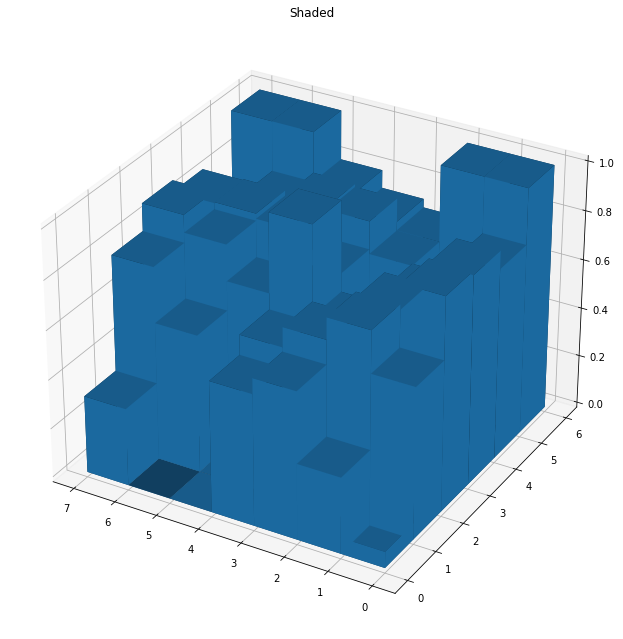

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# first we need a grid for the number of dragons and heralds
data = {} # keys will be # of dragons, values will be a new dictionary with number of barons
# values of the data[# of drag][# of baron] = [wins, losses]
for dragons in range(0,7):
    data[dragons] = {}
    for barons in range(0,6):
        data[dragons][barons] = [0,0]

for index, row in games.iterrows():
    if row['winner'] == 1:
        num_dragons = row['t1_dragonKills']
        num_barons = row['t1_baronKills'] + row['t1_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0] + 1, t[1]]
        
        num_dragons = row['t2_dragonKills']
        num_barons = row['t2_baronKills'] + row['t2_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0], t[1] + 1]
    else:
        num_dragons = row['t1_dragonKills']
        num_barons = row['t1_baronKills'] + row['t1_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0], t[1] + 1]
        
        num_dragons = row['t2_dragonKills']
        num_barons = row['t2_baronKills'] + row['t2_riftHeraldKills']
        t = data[num_dragons][num_barons]
        data[num_dragons][num_barons] = [t[0] + 1, t[1]]
        
for dragons in range(0,7):
    for barons in range(0,6):
        t = data[dragons][barons]
        total_games = t[0] + t[1]
        if total_games > 0:
            data[dragons][barons] = t[0] / total_games
        else:
            data[dragons][barons] = 0
            
data_matrix = np.zeros((7, 6))
for dragons in range(0,7):
    for barons in range(0,6):
        data_matrix[dragons][barons] = data[dragons][barons]
        
#display(data_matrix)

# setup the figure and axes
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121, projection='3d')

# fake data
_x = np.arange(7)
_y = np.arange(6)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = data_matrix.flatten()
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')
ax1.invert_xaxis()

plt.show()

## Resources

[1] https://www.kaggle.com/datasets/datasnaek/league-of-legends?resource=download